# EGCI 425 - Step 3: Attribute Selection

**Objectives:**
1. Create classification target (Rating_Label) from continuous Ratings
2. Apply 3 different attribute selection methods
3. Compare selected features from each method
4. Identify most important features for classification
5. Create reduced feature sets

**Three Methods:**
1. **Correlation-based Feature Selection** - Statistical relationship with target
2. **Recursive Feature Elimination (RFE)** - Iterative feature removal
3. **Tree-based Feature Importance** - Random Forest importance scores

**Dataset:** 231 movies, 12 features (after preprocessing)

**Classification Target:** Rating_Label (Poor/Average/Good/Excellent)

---
## 1. Import Libraries and Load Data

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection methods
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model evaluation
from sklearn.model_selection import cross_val_score

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load preprocessed data
file_path = 'dataset/step2_preprocessed_data.csv'

df = pd.read_csv(file_path)

print(f"✓ Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()

✓ Dataset loaded successfully!
Shape: 231 rows × 14 columns

First few rows:


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3000,8,9130,4000000.0000,45.0000,1,0,3280543.0000,4632.0000,425,636.0000,1120000.0000
1,22 Jump Street,2014,7.1000,1,192000000,50000000.0000,3306.0000,2,2,583289.0000,3465.0000,61,186.0000,12350000.0000
2,3 Days to Kill,2014,6.2000,1,30700000,28000000.0000,2872.0000,1,0,304861.0000,328.0000,34,47.0000,483000.0000
3,300: Rise of an Empire,2014,6.3000,1,106000000,110000000.0000,3470.0000,2,0,452917.0000,2429.0000,132,590.0000,568000.0000
4,A Haunted House 2,2014,4.7000,8,17300000,3500000.0000,2310.0000,2,0,3145573.0000,12163.0000,610,1082.0000,1923800.0000


---
## 2. Create Classification Target: Rating_Label

We convert continuous Ratings into ordinal categories:

| Ratings Range | Assigned Label |
|---------------|----------------|
| 0 - 4.9       | Poor           |
| 5 - 6.4       | Average        |
| 6.5 - 8.9     | Good           |
| 9 - 10        | Excellent      |

- Based on Ahmed et al. (2015) original paper methodology

In [7]:
print("CREATING CLASSIFICATION TARGET: RATING_LABEL\n")

def assign_rating_label(rating):
    if rating < 5:
        return 'Poor'
    elif rating < 6.5:
        return 'Average'
    elif rating < 9:
        return 'Good'
    else:  # >= 9
        return 'Excellent'

# Apply labeling
df['Rating_Label'] = df['Ratings'].apply(assign_rating_label)

print("\nRating_Label column created successfully!")
df.head()

CREATING CLASSIFICATION TARGET: RATING_LABEL


Rating_Label column created successfully!


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers,Rating_Label
0,13 Sins,2014,6.3000,8,9130,4000000.0000,45.0000,1,0,3280543.0000,4632.0000,425,636.0000,1120000.0000,Average
1,22 Jump Street,2014,7.1000,1,192000000,50000000.0000,3306.0000,2,2,583289.0000,3465.0000,61,186.0000,12350000.0000,Good
2,3 Days to Kill,2014,6.2000,1,30700000,28000000.0000,2872.0000,1,0,304861.0000,328.0000,34,47.0000,483000.0000,Average
3,300: Rise of an Empire,2014,6.3000,1,106000000,110000000.0000,3470.0000,2,0,452917.0000,2429.0000,132,590.0000,568000.0000,Average
4,A Haunted House 2,2014,4.7000,8,17300000,3500000.0000,2310.0000,2,0,3145573.0000,12163.0000,610,1082.0000,1923800.0000,Poor


In [11]:
# Analyze class distribution
print("CLASS DISTRIBUTION ANALYSIS\n")

label_counts = df['Rating_Label'].value_counts()
print("\nClass Counts:")
print("-" * 40)
for label in ['Poor', 'Average', 'Good', 'Excellent']:
    if label in label_counts.index:
        count = label_counts[label]
        percentage = (count / len(df)) * 100
        print(f"{label:15s}: {count:3d} movies ({percentage:5.1f}%)")
    else:
        print(f"{label:15s}:   0 movies (  0.0%)")

print(f"\nTotal: {len(df)} movies")

# Check for class imbalance
print("\nCLASS IMBALANCE CHECK")

if len(label_counts) < 4:
    missing_classes = set(['Poor', 'Average', 'Good', 'Excellent']) - set(label_counts.index)
    print(f"   Missing classes: {missing_classes}")
    print("   Consider: Merging classes or adjusting thresholds")

min_class_pct = (label_counts.min() / len(df)) * 100
max_class_pct = (label_counts.max() / len(df)) * 100

if max_class_pct / min_class_pct > 3:
    print(f"   Largest class: {max_class_pct:.1f}%")
    print(f"   Smallest class: {min_class_pct:.1f}%")
    print(f"   Imbalance ratio: {max_class_pct/min_class_pct:.1f}:1")
else:
    print("\nClasses are relatively balanced")

CLASS DISTRIBUTION ANALYSIS


Class Counts:
----------------------------------------
Poor           :  18 movies (  7.8%)
Average        :  93 movies ( 40.3%)
Good           : 120 movies ( 51.9%)
Excellent      :   0 movies (  0.0%)

Total: 231 movies

CLASS IMBALANCE CHECK
   Missing classes: {'Excellent'}
   Consider: Merging classes or adjusting thresholds
   Largest class: 51.9%
   Smallest class: 7.8%
   Imbalance ratio: 6.7:1


---
## 3. Prepare Data for Attribute Selection

In [13]:
print("DATA PREPARATION")

# Exclude 'Ratings' and 'Gross' from features
# - Ratings: Used to create Rating_Label (target), so we can't use it as feature
# - Gross: Not available before movie release

exclude_cols = ['Movie', 'Ratings', 'Rating_Label', 'Gross']
feature_cols = [col for col in df.columns if col not in exclude_cols]
target_col = 'Rating_Label'

X = df[feature_cols]
y = df[target_col]

print(f"\n Features (X): {X.shape}")
print(f"  Columns: {list(X.columns)}")
print(f"\n Target (y): {y.shape}")
print(f"  Variable: {target_col}")
print(f"  Classes: {sorted(y.unique())}")
print(f"  Number of classes: {y.nunique()}")

print(f"\n Data Quality Check:")
print(f"  Missing values in X: {X.isnull().sum().sum()}")
print(f"  Missing values in y: {y.isnull().sum()}")

if X.isnull().sum().sum() == 0 and y.isnull().sum() == 0:
    print("\nData is clean and ready for attribute selection!")
else:
    print("\nMissing values detected!")

DATA PREPARATION

 Features (X): (231, 11)
  Columns: ['Year', 'Genre', 'Budget', 'Screens', 'Sequel', 'Sentiment', 'Views', 'Likes', 'Dislikes', 'Comments', 'Aggregate Followers']

 Target (y): (231,)
  Variable: Rating_Label
  Classes: ['Average', 'Good', 'Poor']
  Number of classes: 3

 Data Quality Check:
  Missing values in X: 0
  Missing values in y: 0

Data is clean and ready for attribute selection!


In [15]:
# Encode target variable for algorithms that require numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("LABEL ENCODING")
print("\nOriginal labels → Encoded values:")
for i, label in enumerate(le.classes_):
    print(f"  {label:15s} → {i}")

df.head()

LABEL ENCODING

Original labels → Encoded values:
  Average         → 0
  Good            → 1
  Poor            → 2


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers,Rating_Label
0,13 Sins,2014,6.3000,8,9130,4000000.0000,45.0000,1,0,3280543.0000,4632.0000,425,636.0000,1120000.0000,Average
1,22 Jump Street,2014,7.1000,1,192000000,50000000.0000,3306.0000,2,2,583289.0000,3465.0000,61,186.0000,12350000.0000,Good
2,3 Days to Kill,2014,6.2000,1,30700000,28000000.0000,2872.0000,1,0,304861.0000,328.0000,34,47.0000,483000.0000,Average
3,300: Rise of an Empire,2014,6.3000,1,106000000,110000000.0000,3470.0000,2,0,452917.0000,2429.0000,132,590.0000,568000.0000,Average
4,A Haunted House 2,2014,4.7000,8,17300000,3500000.0000,2310.0000,2,0,3145573.0000,12163.0000,610,1082.0000,1923800.0000,Poor


---
## 4. Method 1: Correlation-Based Feature Selection

In [16]:
print("METHOD 1: CORRELATION-BASED FEATURE SELECTION")

# Use ANOVA F-statistic for classification
k = 6  # Select top 6 features
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X, y_encoded)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values('F-Score', ascending=False)

print("\nFeature Scores (ANOVA F-statistic):")
print("-" * 60)
for idx, row in feature_scores.iterrows():
    rank = feature_scores.index.get_loc(idx) + 1
    sig = "***" if row['P-Value'] < 0.001 else "**" if row['P-Value'] < 0.01 else "*" if row['P-Value'] < 0.05 else ""
    print(f"{rank:2d}. {row['Feature']:25s}: F={row['F-Score']:8.2f}, p={row['P-Value']:.4f} {sig}")

print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05")

# Select top k features
selected_features_corr = feature_scores.head(k)['Feature'].tolist()

print(f"\n" + "="*60)
print(f"SELECTED FEATURES (Top {k} by F-score):")
print("="*60)
for idx, feature in enumerate(selected_features_corr, 1):
    f_score = feature_scores[feature_scores['Feature'] == feature]['F-Score'].values[0]
    print(f"{idx}. {feature} (F-score: {f_score:.2f})")

# Store results
method1_results = {
    'method': 'Correlation-Based (ANOVA F-test)',
    'selected_features': selected_features_corr,
    'n_features': k,
    'scores': dict(zip(feature_scores['Feature'], feature_scores['F-Score']))
}

METHOD 1: CORRELATION-BASED FEATURE SELECTION

Feature Scores (ANOVA F-statistic):
------------------------------------------------------------
 1. Dislikes                 : F=    5.91, p=0.0031 **
 2. Budget                   : F=    5.13, p=0.0066 **
 3. Sentiment                : F=    2.97, p=0.0534 
 4. Aggregate Followers      : F=    2.06, p=0.1301 
 5. Genre                    : F=    1.74, p=0.1776 
 6. Comments                 : F=    0.34, p=0.7140 
 7. Year                     : F=    0.27, p=0.7671 
 8. Screens                  : F=    0.20, p=0.8182 
 9. Sequel                   : F=    0.16, p=0.8493 
10. Likes                    : F=    0.14, p=0.8730 
11. Views                    : F=    0.02, p=0.9798 

Significance codes: *** p<0.001, ** p<0.01, * p<0.05

SELECTED FEATURES (Top 6 by F-score):
1. Dislikes (F-score: 5.91)
2. Budget (F-score: 5.13)
3. Sentiment (F-score: 2.97)
4. Aggregate Followers (F-score: 2.06)
5. Genre (F-score: 1.74)
6. Comments (F-score: 0.34)


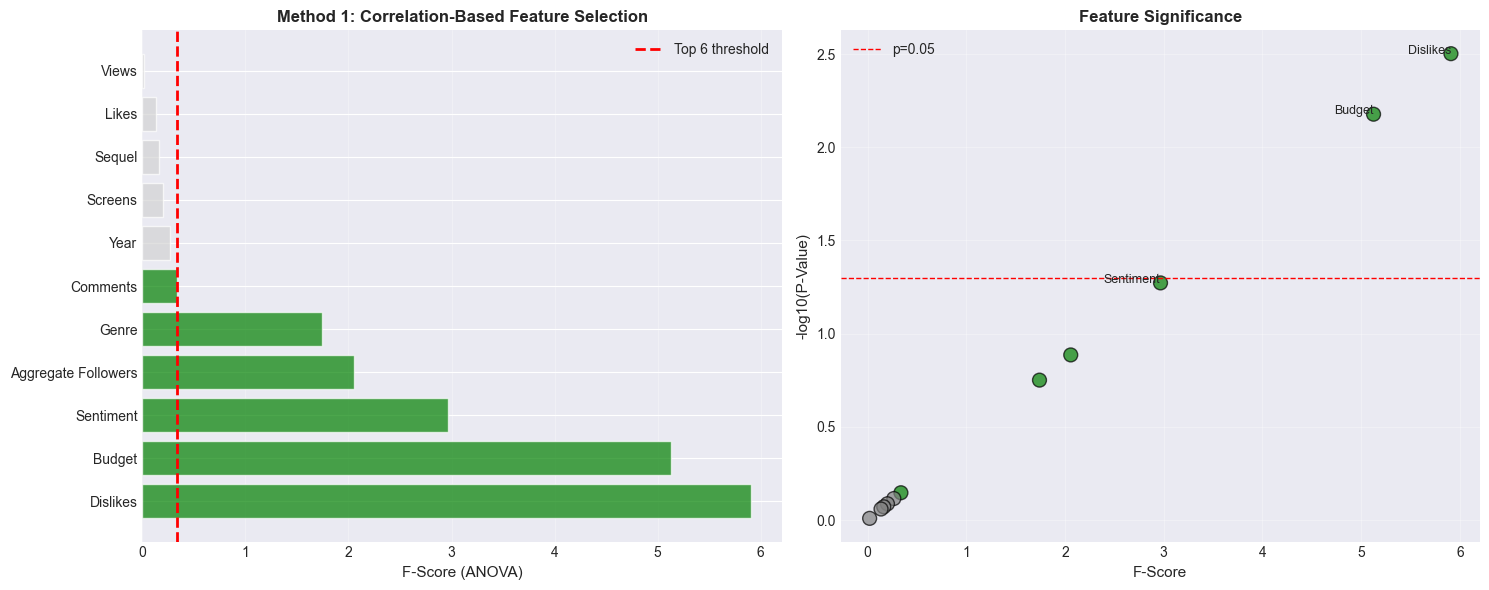


Top 6 features selected based on ANOVA F-test


In [17]:
# Visualize feature scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of F-scores
colors = ['green' if f in selected_features_corr else 'lightgray' for f in feature_scores['Feature']]
axes[0].barh(feature_scores['Feature'], feature_scores['F-Score'], color=colors, alpha=0.7)
axes[0].set_xlabel('F-Score (ANOVA)', fontsize=11)
axes[0].set_title('Method 1: Correlation-Based Feature Selection', fontsize=12, fontweight='bold')
axes[0].axvline(x=feature_scores['F-Score'].iloc[k-1], color='red', linestyle='--', 
               linewidth=2, label=f'Top {k} threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Scatter plot: F-score vs P-value
colors_scatter = ['green' if f in selected_features_corr else 'gray' for f in feature_scores['Feature']]
axes[1].scatter(feature_scores['F-Score'], -np.log10(feature_scores['P-Value']), 
               c=colors_scatter, s=100, alpha=0.7, edgecolors='black')
axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='p=0.05')
axes[1].set_xlabel('F-Score', fontsize=11)
axes[1].set_ylabel('-log10(P-Value)', fontsize=11)
axes[1].set_title('Feature Significance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add feature labels
for idx, row in feature_scores.iterrows():
    if row['Feature'] in selected_features_corr[:3]:  # Label top 3
        axes[1].annotate(row['Feature'], 
                        (row['F-Score'], -np.log10(row['P-Value'])),
                        fontsize=9, ha='right')

plt.tight_layout()
plt.show()

print(f"\nTop {k} features selected based on ANOVA F-test")

---
## 5. Method 2: Recursive Feature Elimination (RFE)

In [19]:
print("METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)")

# Use Random Forest as the estimator for RFE
estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Apply RFE to select top k features
print(f"\nRunning RFE with Random Forest Classifier (selecting {k} features)...")

rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
rfe.fit(X, y_encoded)

# Get selected features
selected_features_rfe = X.columns[rfe.support_].tolist()
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

print("\n RFE Complete!")
print("\nFeature Rankings (1 = selected):")
print("-" * 50)
print(feature_ranking.to_string(index=False))

print(f"\n" + "="*60)
print(f"SELECTED FEATURES (RFE - Top {k}):")
print("="*60)
for idx, feature in enumerate(selected_features_rfe, 1):
    print(f"{idx}. {feature}")

# Store results
method2_results = {
    'method': 'Recursive Feature Elimination',
    'selected_features': selected_features_rfe,
    'n_features': k,
    'rankings': dict(zip(X.columns, rfe.ranking_))
}

METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)

Running RFE with Random Forest Classifier (selecting 6 features)...

 RFE Complete!

Feature Rankings (1 = selected):
--------------------------------------------------
            Feature  Ranking  Selected
            Screens        1      True
             Budget        1      True
              Likes        1      True
           Dislikes        1      True
           Comments        1      True
Aggregate Followers        1      True
          Sentiment        2     False
              Views        3     False
              Genre        4     False
               Year        5     False
             Sequel        6     False

SELECTED FEATURES (RFE - Top 6):
1. Budget
2. Screens
3. Likes
4. Dislikes
5. Comments
6. Aggregate Followers


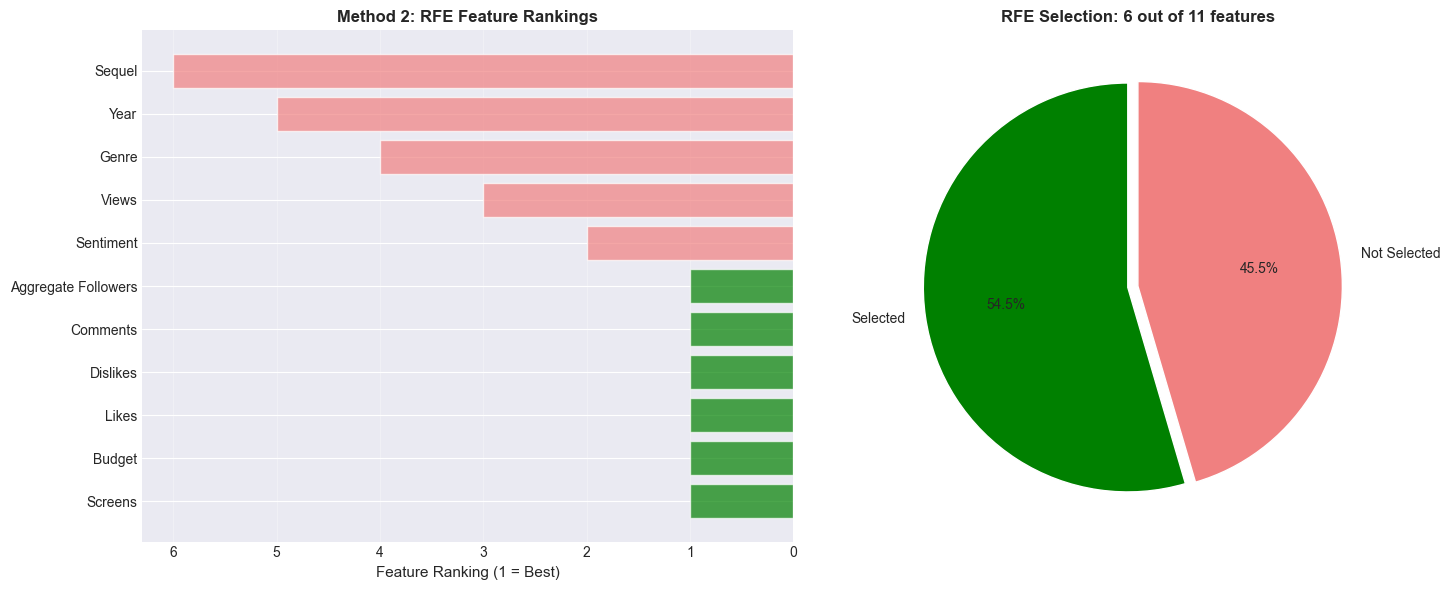


 RFE selected 6 features using Random Forest Classifier


In [20]:
# Visualize RFE results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ranking plot
colors = ['green' if rank == 1 else 'lightcoral' for rank in feature_ranking['Ranking']]
axes[0].barh(feature_ranking['Feature'], feature_ranking['Ranking'], color=colors, alpha=0.7)
axes[0].set_xlabel('Feature Ranking (1 = Best)', fontsize=11)
axes[0].set_title('Method 2: RFE Feature Rankings', fontsize=12, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Selected vs Not Selected
selection_counts = feature_ranking['Selected'].value_counts()
axes[1].pie(selection_counts.values, 
           labels=['Selected', 'Not Selected'],
           colors=['green', 'lightcoral'],
           autopct='%1.1f%%',
           startangle=90,
           explode=(0.05, 0))
axes[1].set_title(f'RFE Selection: {k} out of {len(X.columns)} features', 
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n RFE selected {k} features using Random Forest Classifier")

---
## 6. Method 3: Tree-Based Feature Importance

In [21]:
print("METHOD 3: TREE-BASED FEATURE IMPORTANCE")

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X, y_encoded)

# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n✓ Training Complete!")
print("\nFeature Importances:")
print("-" * 50)
for idx, row in importances.iterrows():
    rank = importances.index.get_loc(idx) + 1
    print(f"{rank:2d}. {row['Feature']:25s}: {row['Importance']:.4f}")

# Select top k features
selected_features_tree = importances.head(k)['Feature'].tolist()

print(f"\n" + "="*60)
print(f"SELECTED FEATURES (Tree-based - Top {k}):")
print("="*60)
for idx, feature in enumerate(selected_features_tree, 1):
    importance_score = importances[importances['Feature'] == feature]['Importance'].values[0]
    print(f"{idx}. {feature} (importance: {importance_score:.4f})")

# Store results
method3_results = {
    'method': 'Tree-Based Importance',
    'selected_features': selected_features_tree,
    'n_features': k,
    'scores': dict(zip(importances['Feature'], importances['Importance']))
}

METHOD 3: TREE-BASED FEATURE IMPORTANCE

✓ Training Complete!

Feature Importances:
--------------------------------------------------
 1. Budget                   : 0.1353
 2. Dislikes                 : 0.1232
 3. Screens                  : 0.1203
 4. Sentiment                : 0.1129
 5. Comments                 : 0.1082
 6. Aggregate Followers      : 0.1062
 7. Likes                    : 0.1053
 8. Views                    : 0.0868
 9. Genre                    : 0.0589
10. Sequel                   : 0.0217
11. Year                     : 0.0212

SELECTED FEATURES (Tree-based - Top 6):
1. Budget (importance: 0.1353)
2. Dislikes (importance: 0.1232)
3. Screens (importance: 0.1203)
4. Sentiment (importance: 0.1129)
5. Comments (importance: 0.1082)
6. Aggregate Followers (importance: 0.1062)


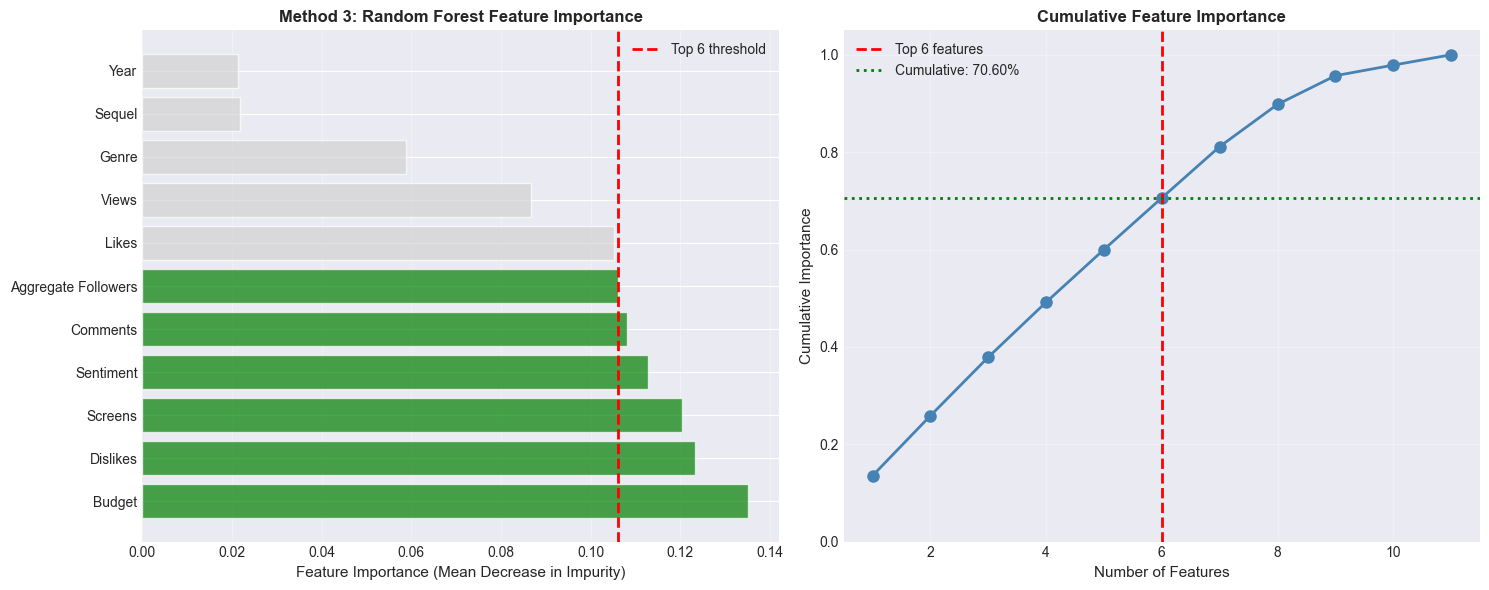

In [23]:
# Visualize feature importances
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of all importances
colors = ['green' if f in selected_features_tree else 'lightgray' for f in importances['Feature']]
axes[0].barh(importances['Feature'], importances['Importance'], color=colors, alpha=0.7)
axes[0].set_xlabel('Feature Importance (Mean Decrease in Impurity)', fontsize=11)
axes[0].set_title('Method 3: Random Forest Feature Importance', fontsize=12, fontweight='bold')
axes[0].axvline(x=importances['Importance'].iloc[k-1], color='red', linestyle='--', 
               linewidth=2, label=f'Top {k} threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Cumulative importance
cumulative_importance = importances['Importance'].cumsum()
axes[1].plot(range(1, len(cumulative_importance)+1), cumulative_importance, 
            marker='o', linewidth=2, markersize=8, color='steelblue')
axes[1].axvline(x=k, color='red', linestyle='--', linewidth=2, label=f'Top {k} features')
axes[1].axhline(y=cumulative_importance.iloc[k-1], color='green', linestyle=':', 
               linewidth=2, label=f'Cumulative: {cumulative_importance.iloc[k-1]:.2%}')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

---
## 7. Compare Results from All Three Methods

In [25]:
print("COMPARISON OF ALL THREE METHODS\n")

# Create comparison table
all_features = X.columns.tolist()
comparison_data = []

for feature in all_features:
    comparison_data.append({
        'Feature': feature,
        'Method 1 (Corr)': '/' if feature in selected_features_corr else '',
        'Method 2 (RFE)': '/' if feature in selected_features_rfe else '',
        'Method 3 (Tree)': '/' if feature in selected_features_tree else '',
        'Selected Count': sum([
            feature in selected_features_corr,
            feature in selected_features_rfe,
            feature in selected_features_tree
        ])
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Selected Count', ascending=False)

print("\nFeature Selection Summary:")
print("-" * 80)
print(comparison_df.to_string(index=False))

# Find consensus features (selected by all 3 methods)
consensus_features = comparison_df[comparison_df['Selected Count'] == 3]['Feature'].tolist()
majority_features = comparison_df[comparison_df['Selected Count'] >= 2]['Feature'].tolist()

print("CONSENSUS ANALYSIS")

print(f"\nFeatures selected by ALL 3 methods ({len(consensus_features)}):")
for idx, feature in enumerate(consensus_features, 1):
    print(f"  {idx}. {feature}")

print(f"\nFeatures selected by AT LEAST 2 methods ({len(majority_features)}):")
for idx, feature in enumerate(majority_features, 1):
    count = comparison_df[comparison_df['Feature'] == feature]['Selected Count'].values[0]
    print(f"  {idx}. {feature} (selected by {count}/3 methods)")

print(f"\nFeatures selected by ONLY 1 method:")
single_method_features = comparison_df[comparison_df['Selected Count'] == 1]['Feature'].tolist()
for idx, feature in enumerate(single_method_features, 1):
    methods = []
    if feature in selected_features_corr:
        methods.append('Correlation')
    if feature in selected_features_rfe:
        methods.append('RFE')
    if feature in selected_features_tree:
        methods.append('Tree-based')
    print(f"  {idx}. {feature} ({', '.join(methods)})")

COMPARISON OF ALL THREE METHODS


Feature Selection Summary:
--------------------------------------------------------------------------------
            Feature Method 1 (Corr) Method 2 (RFE) Method 3 (Tree)  Selected Count
             Budget               /              /               /               3
Aggregate Followers               /              /               /               3
           Comments               /              /               /               3
           Dislikes               /              /               /               3
            Screens                              /               /               2
          Sentiment               /                              /               2
              Genre               /                                              1
              Likes                              /                               1
               Year                                                              0
              Views         

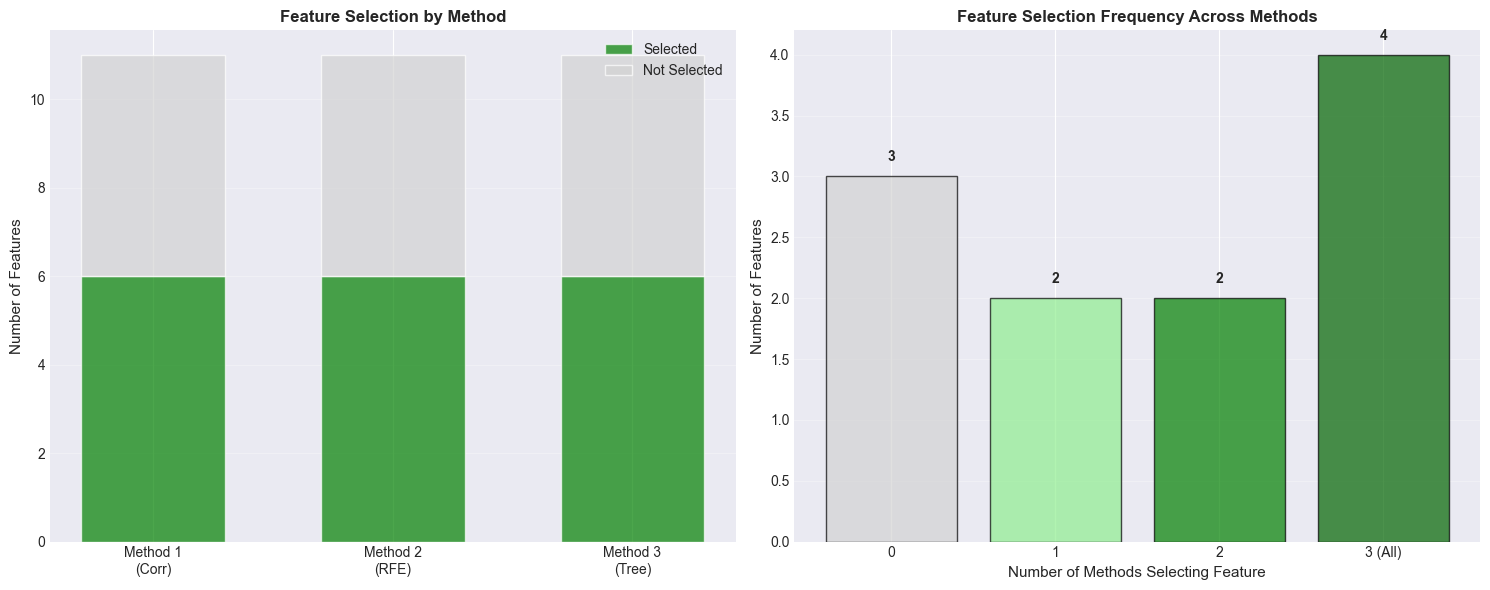

In [26]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart showing selection by each method
methods = ['Method 1\n(Corr)', 'Method 2\n(RFE)', 'Method 3\n(Tree)']
selected_counts = [
    len(selected_features_corr),
    len(selected_features_rfe),
    len(selected_features_tree)
]
not_selected = [len(X.columns) - count for count in selected_counts]

x = np.arange(len(methods))
width = 0.6

axes[0].bar(x, selected_counts, width, label='Selected', color='green', alpha=0.7)
axes[0].bar(x, not_selected, width, bottom=selected_counts, label='Not Selected', 
           color='lightgray', alpha=0.7)
axes[0].set_ylabel('Number of Features', fontsize=11)
axes[0].set_title('Feature Selection by Method', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Selection frequency
selection_freq = comparison_df['Selected Count'].value_counts().sort_index(ascending=False)
colors_freq = ['darkgreen', 'green', 'lightgreen', 'lightgray']
axes[1].bar(selection_freq.index, selection_freq.values, 
           color=colors_freq[:len(selection_freq)], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Number of Methods Selecting Feature', fontsize=11)
axes[1].set_ylabel('Number of Features', fontsize=11)
axes[1].set_title('Feature Selection Frequency Across Methods', fontsize=12, fontweight='bold')
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(['0', '1', '2', '3 (All)'])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(selection_freq.values):
    axes[1].text(selection_freq.index[i], v + 0.1, str(v), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8. Choosing Feature Sets

In [27]:
# Majority features (at least 2 methods)
print("\nOPTION 2: MAJORITY FEATURES (Balanced)")
print(f"Features: {len(majority_features)}")
print(f"List: {majority_features}")


OPTION 2: MAJORITY FEATURES (Balanced)
Features: 6
List: ['Budget', 'Aggregate Followers', 'Comments', 'Dislikes', 'Screens', 'Sentiment']


---
## 9. Export Results

In [31]:
df_majority = df[['Movie'] + majority_features + ['Rating_Label']]
df_majority.to_csv('step3_data_majority_features.csv', index=False)
print("Saved: step3_data_majority_features.csv")

Saved: step3_data_majority_features.csv


In [30]:
df_majority.head()

,Movie,Budget,Aggregate Followers,Comments,Dislikes,Screens,Sentiment,Rating_Label
0,13 Sins,4000000.0000,1120000.0000,636.0000,425,45.0000,0,Average
1,22 Jump Street,50000000.0000,12350000.0000,186.0000,61,3306.0000,2,Good
2,3 Days to Kill,28000000.0000,483000.0000,47.0000,34,2872.0000,0,Average
3,300: Rise of an Empire,110000000.0000,568000.0000,590.0000,132,3470.0000,0,Average
4,A Haunted House 2,3500000.0000,1923800.0000,1082.0000,610,2310.0000,0,Poor
